In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

In [14]:
# Load the data
file_path = '../../../Dataset/BTC-USD.csv'
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904


In [15]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    # df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    # df['MA200_low'] = df['Low'].rolling(window=200).min()
    # df['MA14_low'] = df['Low'].rolling(window=14).min()
    # df['MA200_high'] = df['High'].rolling(window=200).max()
    # df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    # df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    # Relative Strength Index (RSI) not using the K-ratio
    # df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    # 
    return df

                  Close       MACD  Bollinger_Upper  Bollinger_Lower         MA26        EMA20
Date                                                                                          
2018-10-02  6556.100098 -10.684094      6792.186134      6313.780956  6502.164645  6584.695354
2018-10-03  6502.589844 -16.371112      6792.002241      6312.492828  6503.530799  6576.875781
2018-10-04  6576.689941 -14.729068      6794.686803      6316.206264  6517.019644  6576.858082
2018-10-05  6622.479980  -9.621947      6800.417097      6318.403948  6529.389648  6581.203025
2018-10-06  6588.310059  -8.236796      6803.448380      6322.485653  6539.336182  6581.879885


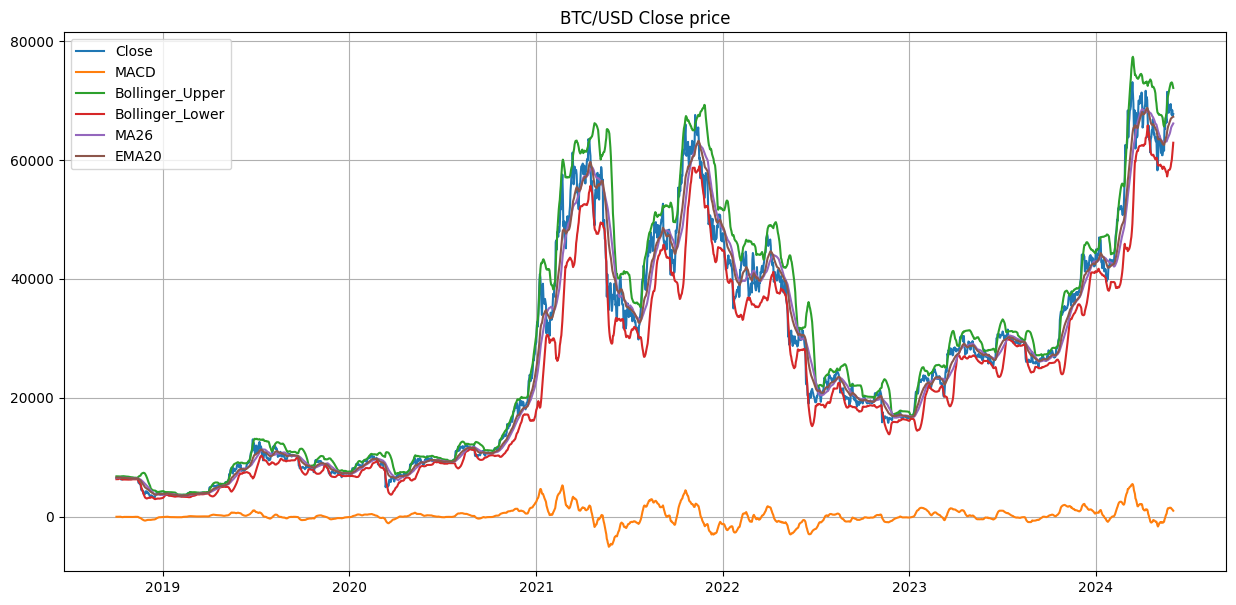

In [16]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            # 'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]
# Create the dataset with features
df_features = createFeatures(df)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()
# Filter the data to the list of FEATURES
df_filtered = df_filtered.dropna()
# Filter the data to the list of FEATURES
print(df_filtered.head().to_string())  
    

# Create the lineplot
plt.style.use('default')
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('BTC/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()

In [17]:
# Training and Test dataset
test_size = 0.3
train_size = int(len(df_filtered) * (1 - test_size))
train, test = df_filtered.iloc[0:train_size], df_filtered.iloc[train_size:len(df_filtered)]

In [18]:
X_train = train.drop('Close', axis=1)
y_train = train['Close']

X_test = test.drop('Close', axis=1)
y_test = test['Close']


In [19]:
# XGBoost
# XGBoost Regressor
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train
        , y_train
        , eval_set=[(X_train, y_train), (X_test, y_test)]
        , early_stopping_rounds=50
       )

[0]	validation_0-rmse:12837.16925	validation_1-rmse:14792.44805
[1]	validation_0-rmse:9106.23951	validation_1-rmse:11444.46600
[2]	validation_0-rmse:6488.13219	validation_1-rmse:9105.64785
[3]	validation_0-rmse:4653.30719	validation_1-rmse:7521.51517
[4]	validation_0-rmse:3371.66836	validation_1-rmse:6404.95133
[5]	validation_0-rmse:2488.91400	validation_1-rmse:5581.59598
[6]	validation_0-rmse:1880.12131	validation_1-rmse:4932.11294
[7]	validation_0-rmse:1461.46005	validation_1-rmse:4520.35603
[8]	validation_0-rmse:1184.25211	validation_1-rmse:4276.40276
[9]	validation_0-rmse:992.50939	validation_1-rmse:4077.41712
[10]	validation_0-rmse:868.75560	validation_1-rmse:3966.62071
[11]	validation_0-rmse:784.70683	validation_1-rmse:3887.47530
[12]	validation_0-rmse:729.74085	validation_1-rmse:3831.41574
[13]	validation_0-rmse:695.48012	validation_1-rmse:3789.86167
[14]	validation_0-rmse:660.75182	validation_1-rmse:3759.84430
[15]	validation_0-rmse:641.09701	validation_1-rmse:3730.60270
[16]	v

C:\Users\lequo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:409.88638	validation_1-rmse:3564.78298
[34]	validation_0-rmse:398.84529	validation_1-rmse:3561.80631
[35]	validation_0-rmse:385.91152	validation_1-rmse:3562.74160
[36]	validation_0-rmse:375.97182	validation_1-rmse:3563.04810
[37]	validation_0-rmse:367.31654	validation_1-rmse:3561.62493
[38]	validation_0-rmse:355.86119	validation_1-rmse:3560.98305
[39]	validation_0-rmse:353.80551	validation_1-rmse:3554.98481
[40]	validation_0-rmse:350.53012	validation_1-rmse:3553.40108
[41]	validation_0-rmse:348.33201	validation_1-rmse:3553.43537
[42]	validation_0-rmse:340.54600	validation_1-rmse:3579.95253
[43]	validation_0-rmse:334.63115	validation_1-rmse:3580.10627
[44]	validation_0-rmse:330.80361	validation_1-rmse:3579.55578
[45]	validation_0-rmse:324.57388	validation_1-rmse:3579.91888
[46]	validation_0-rmse:320.82760	validation_1-rmse:3582.43209
[47]	validation_0-rmse:314.93789	validation_1-rmse:3582.81740
[48]	validation_0-rmse:305.66653	validation_1-rmse:3583.43045
[49]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

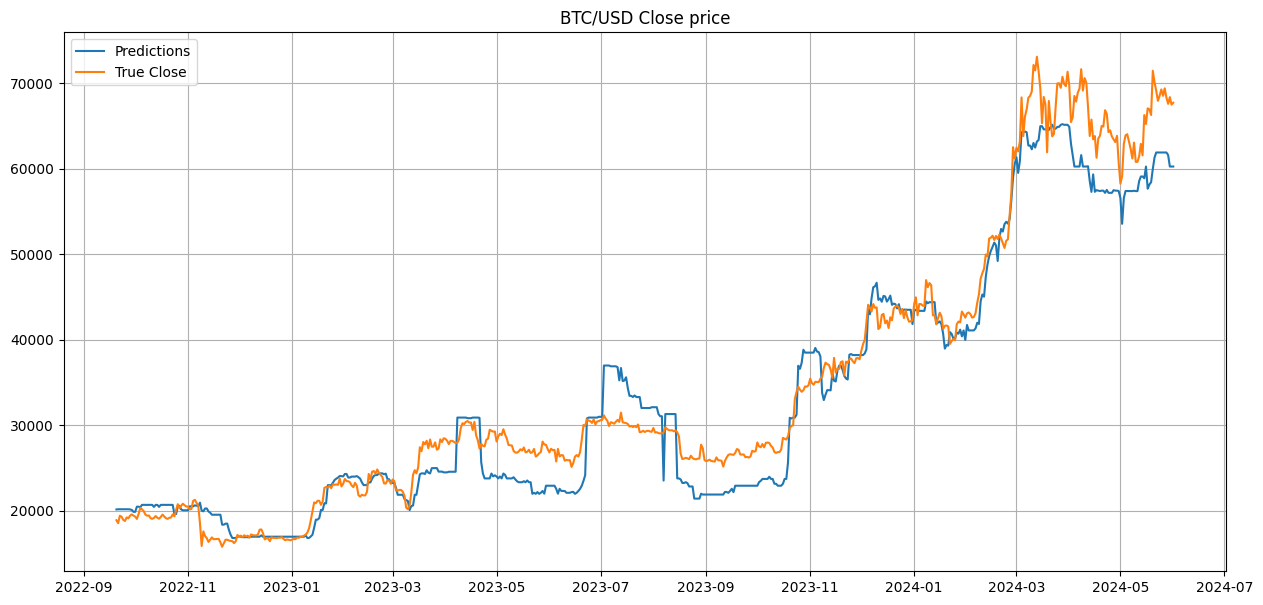

In [20]:
# Make predictions for validation and test sets
test_preds = reg.predict(X_test)

# plot the predictions
plt.figure(figsize=(15, 7))
plt.plot(test.index, test_preds, label='Predictions')
plt.plot(test.index, test['Close'], label='True Close')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()

In [21]:
# Create function to forecast next x days
def forecast_next_x_days(df, num_days, best_model):

    print(f"Forecasting for day {num_days}")
    # Predict 1 day ahead and use the forecasted value to create features for the next day
    df_forecast = df.copy()
    for i in range(num_days):
        # Create the forecast's exogenous variables
        lag_feature_input = df_forecast.iloc[-1].drop('Close').copy()
        print(f"Forecasting for day {i+1}")
        forecast_1_ahead = best_model.predict(lag_feature_input.values.reshape(1, -1))
        print(f"Forecasted value for day {i+1}: {forecast_1_ahead[0]}") 
        # Append the forecasted value to the dataset 
        lag_feature_input['Close'] = forecast_1_ahead[0]
        df_forecast_extend = pd.DataFrame([lag_feature_input], columns=df_forecast.columns)
        df_forecast = pd.concat([df_forecast, df_forecast_extend], axis=0)
        df_forecast.index = pd.date_range(start=df_forecast.index.min(), periods=len(df_forecast))
        # Create the features for the next day
        df_forecast = createFeatures(df_forecast)
        # Filter the data to the list of FEATURES
        df_forecast = df_forecast[FEATURES].copy()

        
    return df_forecast[-num_days:]

In [22]:
fc_90_day = forecast_next_x_days(df_filtered, 90, reg)
fc_60_day = forecast_next_x_days(df_filtered, 60, reg)
fc_30_day = forecast_next_x_days(df_filtered, 30, reg)

Forecasting for day 90
Forecasting for day 1
Forecasted value for day 1: 60250.390625
Forecasting for day 2
Forecasted value for day 2: 57490.63671875
Forecasting for day 3
Forecasted value for day 3: 57183.71875
Forecasting for day 4
Forecasted value for day 4: 57386.7578125
Forecasting for day 5
Forecasted value for day 5: 56280.58984375
Forecasting for day 6
Forecasted value for day 6: 52780.75390625
Forecasting for day 7
Forecasted value for day 7: 52780.75390625
Forecasting for day 8
Forecasted value for day 8: 51708.6640625
Forecasting for day 9
Forecasted value for day 9: 51481.44140625
Forecasting for day 10
Forecasted value for day 10: 51848.421875
Forecasting for day 11
Forecasted value for day 11: 52747.2578125
Forecasting for day 12
Forecasted value for day 12: 52839.21875
Forecasting for day 13
Forecasted value for day 13: 53096.75
Forecasting for day 14
Forecasted value for day 14: 50289.18359375
Forecasting for day 15
Forecasted value for day 15: 50725.75390625
Forecasti

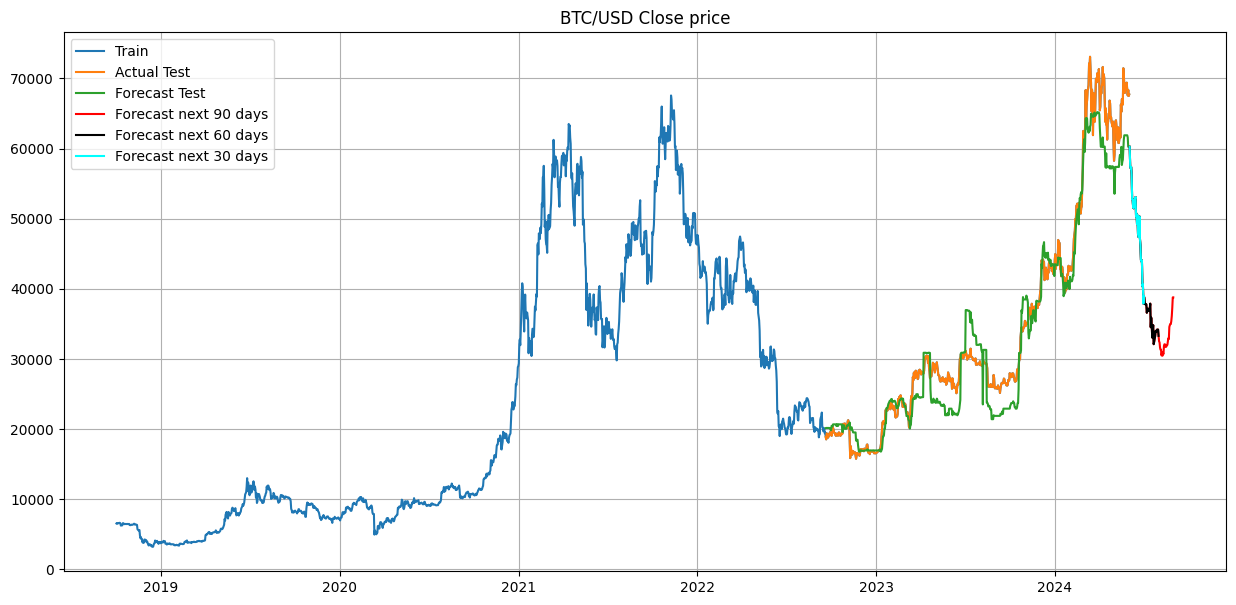

In [23]:
df_forecast_90 = fc_90_day.copy()
df_forecast_90.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_90))

df_forecast_60 = fc_60_day.copy()
df_forecast_60.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_60))

df_forecast_30 = fc_30_day.copy()
df_forecast_30.index = pd.date_range(start=df_filtered.index.max() + dt.timedelta(days=1), periods=len(df_forecast_30))


# Plot the overall with connection to forecast
plt.figure(figsize=(15, 7))
plt.plot(df_filtered['Close'], label='Train')
plt.plot(test.index, y_test, label='Actual Test')
plt.plot(test.index, test_preds, label='Forecast Test')
plt.plot(df_forecast_90.index, df_forecast_90['Close'], label='Forecast next 90 days', color='red')
plt.plot(df_forecast_60.index, df_forecast_60['Close'], label='Forecast next 60 days', color='black')
plt.plot(df_forecast_30.index, df_forecast_30['Close'], label='Forecast next 30 days', color='cyan')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()

In [24]:
# Calculate the Model's RMSE, MAPE, and SMAPE
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    return rmse, mape, smape


# Calculate the metrics for the test data
rmse, mape, smape = calculate_metrics(y_test, test_preds)
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}")
print(f"SMAPE: {smape:.2f}")

RMSE: 3553.40
MAPE: 8.20
SMAPE: 8.46
